In [14]:
#Double Dueling DQN faster train
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions

class InputLayers(nn.Module):
    def __init__(self, board_size):
        super(InputLayers, self).__init__()
        self.board_size = board_size
        self.conv1 = nn.Conv2d(2, 128, kernel_size=3, stride=1, padding="same")
    def forward(self, x):
        x = x.view(-1, 2, board_size, board_size)  # batch_size x channels x board_x x board_y
        x = F.elu(self.conv1(x))
        return x
    
class BoardFeatures(nn.Module):
    def __init__(self, inplanes=128, planes=128):
        super(BoardFeatures, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding="same")
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding="same")
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.elu(out)
        out = self.conv2(out)
        out = F.elu(out)
        out += residual
        return out
    
class OutputLayers(nn.Module):
    def __init__(self, board_size):
        super(OutputLayers, self).__init__()
        self.board_size = board_size
        self.dense_size = 512
        self.conv_policy = nn.Conv2d(128, self.dense_size, kernel_size=3, padding="same")
        self.ln1 = nn.Linear(self.board_size ** 2 * self.dense_size, self.dense_size)
        self.advantage = nn.Linear(self.dense_size, board_size**2)
        self.value = nn.Linear(self.dense_size, 1)
    def forward(self, board_features):
        policy_head = F.elu(self.conv_policy(board_features))
        policy_head = policy_head.view(-1, self.board_size**2*self.dense_size)
        x = F.elu(self.ln1(policy_head))
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage - advantage.mean()
       
class DQN(nn.Module):
    def __init__(self, board_size):
        super(DQN, self).__init__()
        self.loss = 0.0
        self.conv = InputLayers(board_size)
        for block in range(1):
            setattr(self, "res_%i" % block,BoardFeatures())
        self.outblock = OutputLayers(board_size)
    
    def forward(self,s):
        s = self.conv(s)
        for block in range(1):
            s = getattr(self, "res_%i" % block)(s)
        s = self.outblock(s)
        return s
    
def train_dueling_dqn(model, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    
    transitions = memory.sample(batch_size)
    state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)
    
    state_batch = torch.stack(state_batch).cuda()
    action_batch = torch.tensor(action_batch).cuda()
    next_state_batch = torch.stack(next_state_batch).cuda()
    reward_batch = torch.tensor(reward_batch).cuda()
    done_batch = torch.tensor(done_batch, dtype=torch.int32).cuda()
    
    q_values = model(state_batch).cuda()
    next_q_values = model(next_state_batch).cuda()
    next_q_state_values = target_net(next_state_batch).cuda()
    q_value = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, next_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward_batch + gamma * next_q_value * (1-done_batch)
    
    target_q_values = q_values.clone().detach()
    target_q_values.scatter_(1, action_batch.unsqueeze(1), expected_q_value.unsqueeze(1))
    
    common_loss = F.smooth_l1_loss(q_values, target_q_values.detach())
    future_loss = F.smooth_l1_loss(next_q_values, next_q_state_values)
    loss = (common_loss*0.8+future_loss*0.2)
    model.loss = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Episode 100, Reward -0.1|-0.943 Epsilon 0.01 Closed Cells 40|19.97 Wins 0|0.0 Moves 9|4.03 Loss 0.0018444848246872425
Episode 200, Reward -0.7|-1.081 Epsilon 0.01 Closed Cells 16|24.38 Wins 0|0.0 Moves 5|4.41 Loss 0.002694573486223817
Episode 300, Reward -0.7|-1.087 Epsilon 0.01 Closed Cells 13|20.57 Wins 0|0.0 Moves 3|3.99 Loss 0.0022511393763124943
Episode 400, Reward -0.7|-0.991 Epsilon 0.01 Closed Cells 22|20.27 Wins 0|0.0 Moves 3|4.27 Loss 0.0015073821414262056
Episode 500, Reward -0.7|-0.97 Epsilon 0.01 Closed Cells 29|19.37 Wins 0|0.0 Moves 3|4.18 Loss 0.0030707702971994877
Episode 600, Reward -1.6|-1.015 Epsilon 0.01 Closed Cells 18|19.56 Wins 0|0.0 Moves 6|3.83 Loss 0.0022570951841771603
Episode 700, Reward -1.0|-0.901 Epsilon 0.01 Closed Cells 24|19.69 Wins 0|0.0 Moves 2|4.33 Loss 0.0026967739686369896
Episode 800, Reward -1.3|-0.874 Epsilon 0.01 Closed Cells 9|21.84 Wins 0|0.0 Moves 3|4.56 Loss 0.002261666813865304
Episode 900, Reward -1.0|-1.084 Epsilon 0.01 Closed Cells 13

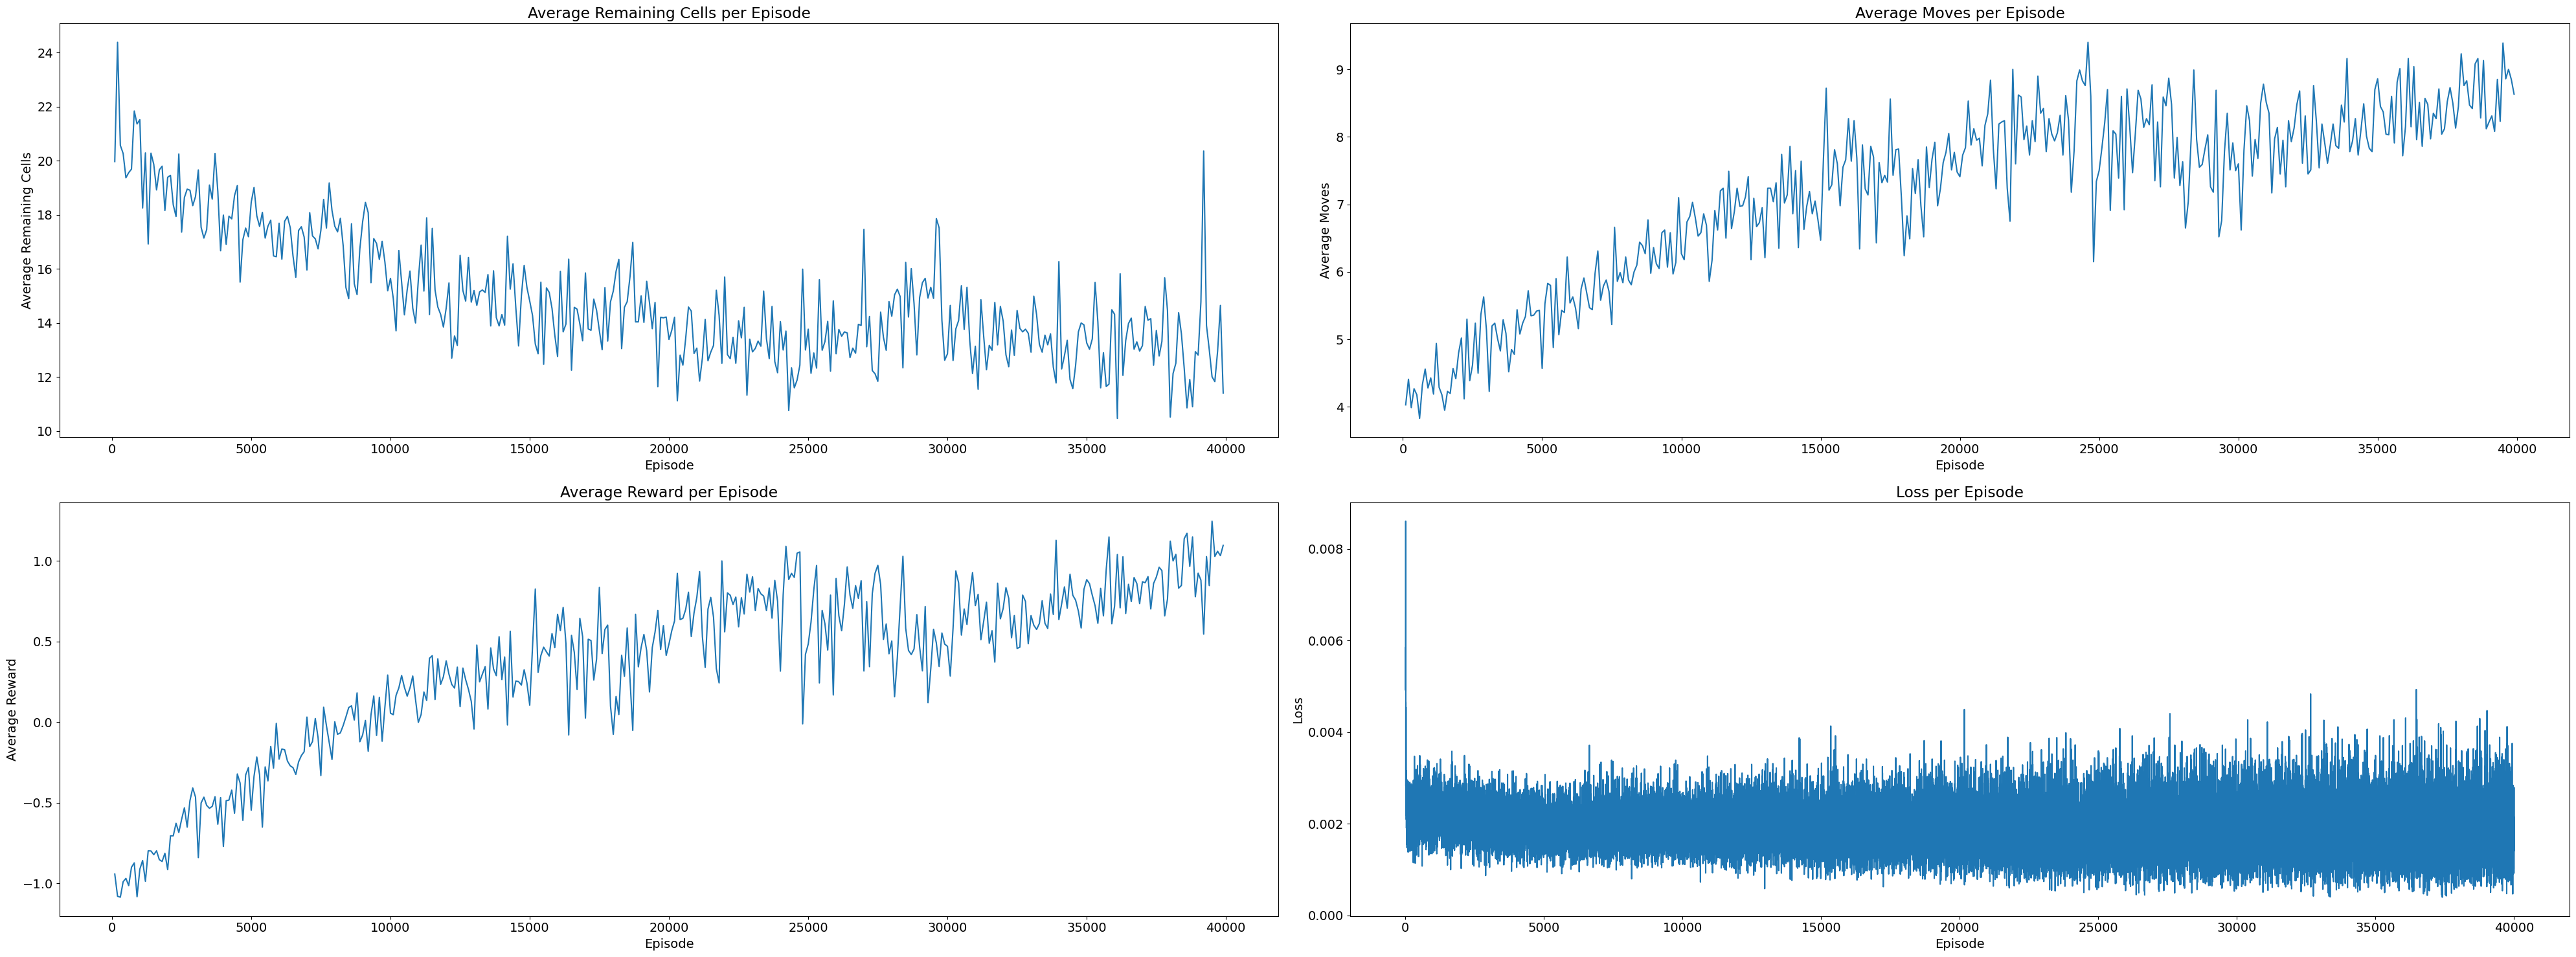

mkdir: cannot create directory 'model_data': File exists
Saved


In [16]:
import random, os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from copy import deepcopy

#%load_ext tensorboard
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter('./runs2')
#%tensorboard --logdir runs

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, next_state, reward, done):
        self.memory.append((state, action, next_state, reward, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)
class boardSpot(object):
    value = 0
    selected = False
    mine = False
    def __init__(self):
        self.selected = False
    def __str__(self):
        return str(boardSpot.value)
    def isMine(self):
        if boardSpot.value == -1:
            return True
        return False
class boardClass(object):
    def __init__(self, m_boardSize, m_numMines):
        self.board = [[boardSpot() for i in range(m_boardSize)] for j in range(m_boardSize)]
        self.boardSize = m_boardSize
        self.numMines = m_numMines
        self.selectableSpots = m_boardSize * m_boardSize - m_numMines
        self.firstMove = True
    def __str__(self):
        returnString = " "
        divider = "\n---"
        for i in range(0, self.boardSize):
            returnString += " | " + str(i)
            divider += "----"
        divider += "\n"
        returnString += divider
        for y in range(0, self.boardSize):
            returnString += str(y)
            for x in range(0, self.boardSize):
                if self.board[x][y].mine and self.board[x][y].selected:
                    returnString += " |" + str(self.board[x][y].value)
                elif self.board[x][y].selected:
                    returnString += " | " + str(self.board[x][y].value)
                else:
                    returnString += " |  "
            returnString += " |"
            returnString += divider
        return returnString
    def makeMove(self, x, y):
        if self.firstMove:
            self.firstMove = False
            self.makeLevel(x, y)
        if self.board[x][y].selected:
            print("You made this move before")
            return True
        self.board[x][y].selected = True
        self.selectableSpots -= 1
        if self.board[x][y].value == -1:
            return False
        if self.board[x][y].value == 0:
            for i in range(x-1, x+2):
                if i >= 0 and i < self.boardSize:
                    if y-1 >= 0 and not self.board[i][y-1].selected:
                        self.makeMove(i, y-1)
                    if y+1 < self.boardSize and not self.board[i][y+1].selected:
                        self.makeMove(i, y+1)
            if x-1 >= 0 and not self.board[x-1][y].selected:
                self.makeMove(x-1, y)
            if x+1 < self.boardSize and not self.board[x+1][y].selected:
                self.makeMove(x+1, y)
            return True
        else:
            return True
    def hitMine(self, x, y):
        return self.board[x][y].value == -1
    def isWinner(self):
        return self.selectableSpots == 0
    def addMine(self, x, y):
        self.board[x][y].value = -1
        self.board[x][y].mine = True
        for i in range(x-1, x+2):
            if i >= 0 and i < self.boardSize:
                for j in range(y-1, y+2):
                    if j >= 0 and j < self.boardSize and not self.board[i][j].mine:
                        self.board[i][j].value += 1
                        if self.board[i][j].value == 0:
                            self.selectableSpots -= 1
                            
    def makeLevel(self, x, y):
        for _ in range(self.numMines):
            while True:
                randX = random.randint(0, self.boardSize-1)
                randY = random.randint(0, self.boardSize-1)
                # Проверяем, что мина не находится в окрестности первого хода
                if abs(randX - x) <= 1 and abs(randY - y) <= 1:
                    continue
                if not self.board[randX][randY].mine:
                    self.addMine(randX, randY)
                    break
def board_to_matrix(Board):
    matrix = []
    for row in Board.board:
        new_row = []
        for spot in row:
            if spot.selected:
                if spot.value != -1:
                    new_row.append([spot.value, 0])
                else:
                    new_row.append([-0.5, 0])
            else:
                new_row.append([-1, 1])
        matrix.append(new_row)
    return matrix
def playGame():
    boardSize = int(input("Choose the Width of the board: "))
    numMines = int(input("Choose the number of mines: "))
    gameOver = False
    winner = False
    Board = boardClass(boardSize, numMines)
    while not gameOver:
        print(Board)
        print("Make your move:")
        x = int(input("x: "))
        y = int(input("y: "))
        Board.makeMove(x, y)
        gameOver = Board.hitMine(x, y)
        if Board.isWinner() and gameOver == False:
            gameOver = True
            winner = True
    print(Board)
    if winner:
        print("Congratulations, You Win!")
    else:
        print("You hit a mine, Game Over!")
def mask_invalid_moves(probabilities, Board):
    masked_probabilities = probabilities.copy()
    for x in range(Board.boardSize):
        for y in range(Board.boardSize):
            if Board.board[x][y].selected:
                masked_probabilities[x * Board.boardSize + y] = -float('inf')
    return masked_probabilities
def calculate_reward(board, x, y):
    reward = 0
    board_size = board.boardSize
    board = board.board
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue 
            nx, ny = x + dx, y + dy
            if 0 <= nx < board_size and 0 <= ny < board_size:
                if board[nx][ny].selected:
                    reward = 0.3
                    return reward
    return reward
def update_target_net(target_net, source_net, tau):
    for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)
def play_and_train(model, target_net, memory, optimizer, batch_size, gamma, board_size, numMines, num_episodes, target_update, epsilon_start, epsilon_end, epsilon_decay):
    cuda = torch.cuda.is_available()
    epsilon = epsilon_start
    wins = 0
    rewards = []
    spots = []
    moves = []
    average_rewards = []
    average_spots = []
    average_moves = []
    loss_values = []
    target_counter = 0
    showEvery = 100
    for episode in range(1, num_episodes):
        #numMines = random.randint(10, 20)
        Board = boardClass(board_size, numMines)
        state = torch.FloatTensor(board_to_matrix(Board))
        if cuda:
            state = state.cuda()
        total_reward = 0
        move = 0
        first_move = True
        done = False
        while True:
            probabilities = model(state)
            if cuda:
                probabilities = probabilities.cpu()
            probabilities = probabilities.detach().numpy().reshape(-1)
            masked_probabilities = mask_invalid_moves(probabilities, Board)
            if np.random.rand() < epsilon:
                action = np.random.choice(np.flatnonzero(np.isfinite(masked_probabilities)))
            else:
                action = np.argmax(masked_probabilities)
            x, y = action // board_size, action % board_size
            reward_for_predict = calculate_reward(Board, x, y)
            if reward_for_predict == 0:
                reward_for_predict = -0.3
            reward = reward_for_predict
            game_over = Board.makeMove(x, y)
            move+=1
            next_state = torch.FloatTensor(board_to_matrix(Board))
            if cuda:
                next_state = next_state.cuda()
            if Board.isWinner():
                reward = 1.0
                done = True
            elif game_over == False:
                reward = -1.0
                done = True
            if first_move == False:
                total_reward += reward
                memory.push(state, action, next_state, reward, done)
            state = next_state
            first_move = Board.firstMove
            if game_over == False or Board.isWinner():
                rewards.append(total_reward)
                spots.append(Board.selectableSpots)
                moves.append(move)
                if Board.isWinner():
                    wins+=1
                if episode % showEvery == 0:
                    #print(Board)
                    #print(action)
                    #print(np.array(probabilities).reshape(board_size, board_size))
                    #for row in np.array(probabilities).reshape(board_size, board_size):
                    #    print(" ".join(map(lambda x: f"{x:.4f}", row)))
                    if episode % 100 == 0:
                        print(f"Episode {episode}, Reward {round(total_reward, 4)}|{round(sum(rewards)/len(rewards), 4)} Epsilon {round(epsilon, 4)} Closed Cells {Board.selectableSpots}|{round(sum(spots)/len(spots), 4)} Wins {wins}|{wins*100/(episode)} Moves {move}|{round(sum(moves)/len(moves), 4)} Loss {model.loss}")
                    #torch.save({'state_dict': model.state_dict()}, current_net_filename)
                    #print("Saved")
                    average_rewards.append(sum(rewards)/len(rewards))
                    rewards.clear()
                    average_spots.append(sum(spots)/len(spots))
                    spots.clear()
                    average_moves.append(sum(moves)/len(moves))
                    moves.clear()
                total_reward = 0
                break
        target_counter += 1
        train_dueling_dqn(model, target_net, memory, optimizer, batch_size, gamma)
        if episode > 1:
            loss_values.append(model.loss)
        #train_dqn(model, memory, optimizer, batch_size, gamma)
        if target_update<target_counter:
            update_target_net(target_net, model, 0.005)
            #target_net.load_state_dict(model.state_dict())
            target_counter = 0
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        
    plt.figure(figsize=(40, 15))
    plt.subplot(2, 2, 1)
    plt.plot(range(showEvery, num_episodes, showEvery), average_spots)
    plt.xlabel('Episode')
    plt.ylabel('Average Remaining Cells')
    plt.title('Average Remaining Cells per Episode')
    plt.subplot(2, 2, 2)
    plt.plot(range(showEvery, num_episodes, showEvery), average_moves)
    plt.xlabel('Episode')
    plt.ylabel('Average Moves')
    plt.title('Average Moves per Episode')
    plt.subplot(2, 2, 3)
    plt.plot(range(showEvery, num_episodes, showEvery), average_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode')
    plt.subplot(2, 2, 4)
    plt.plot(range(2, num_episodes), loss_values)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Loss per Episode')
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14})
    image_name = f"plots_{board_size}x{board_size}"
    plt.savefig(f'{image_name}.png')
    print("Saved as", image_name)
    plt.show()
board_size = 8
numMines = 10
num_episodes = 40000
batch_size = 32
gamma = 0.9
memory = ReplayMemory(capacity=100000)
net_to_play = f"current_trained_net_{board_size}x{board_size}.pth.tar"
model = DQN(board_size)
cuda = torch.cuda.is_available()
current_net_filename = os.path.join("./model_data/",\
                                net_to_play)
#device = torch.device('cuda' if cuda else 'cpu')
#checkpoint = torch.load(current_net_filename, map_location=device)
#model.load_state_dict(checkpoint['state_dict'])
target_net = DQN(board_size)
#target_net.load_state_dict(model.state_dict())
if cuda:
    model.cuda()
    target_net.cuda()
# model.compile(backend="onnxrt")
# target_net.compile(backend="onnxrt")
optimizer = optim.Adam(model.parameters(), lr=1e-5)
target_update = 5
epsilon_start = 0
epsilon_end = 0.01
epsilon_decay = 0.995
play_and_train(model, target_net, memory, optimizer, batch_size, gamma, board_size, numMines, num_episodes, target_update, epsilon_start, epsilon_end, epsilon_decay)
!mkdir model_data
torch.save({'state_dict': model.state_dict()}, current_net_filename)
print("Saved")

In [ ]:
#Double DQN
class MinesweeperModel(nn.Module):
    def __init__(self, board_size):
        super(MinesweeperModel, self).__init__()
        self.convdim = 128
        self.dense = 512
        self.board_size = board_size
        n_actions = board_size**2
        self.conv1 = nn.Conv2d(2, self.convdim , kernel_size=3, stride = 1)
        self.conv2 = nn.Conv2d(self.convdim, self.convdim, kernel_size=3, stride = 1)
        self.conv3 = nn.Conv2d(self.convdim, self.convdim, kernel_size=3, stride = 1)
        self.conv4 = nn.Conv2d(self.convdim, self.convdim, kernel_size=3, stride = 1)
        self.ln1 =  nn.Linear(self.convdim, self.dense)
        self.head = nn.Linear(self.dense, n_actions)
    
    def forward(self, x): #input (1,1,9,9)
        #print('DQN', x)
        x = x.view(-1, 2, self.board_size, self.board_size)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.ln1(x.view(x.size(0), -1)))
        return self.head(x)
    
def train_dqn(model, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    
    # Получаем случайный батч из памяти
    transitions = memory.sample(batch_size)
    
    # Создаем списки для новых значений Q(s, a) и ожидаемых значений
    original_state_action_values = []
    target_state_action_values = []
    
    # По циклу проходимся по всем записям в батче
    for transition in transitions:
        state, action, next_state, reward, done = transition
        
        # Получаем значения Q(s, a) для текущего состояния и действия
        state_action_values = model(state).reshape(-1)
        target_action_values = state_action_values.clone().detach()
        # Вычисляем значение Q(s', a') для следующего состояния
        if not done:
            next_state_values = target_net(next_state).reshape(-1)
            next_state_value = next_state_values.max().detach()
            expected_state_action_value = reward + gamma * next_state_value
        else:
            expected_state_action_value = reward
        target_action_values[action] = expected_state_action_value
        # Добавляем новые значения Q(s, a) и ожидаемых значений в списки
        original_state_action_values.append(state_action_values)
        target_state_action_values.append(target_action_values)
    
    # Преобразуем списки в тензоры
    original_state_action_values = torch.stack(original_state_action_values)
    target_state_action_values = torch.stack(target_state_action_values)
    
    # Вычисляем потери и обновляем веса модели
    loss = F.smooth_l1_loss(original_state_action_values, target_state_action_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
#Double Dueling DQN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class MinesweeperModel(nn.Module):
    def __init__(self, board_size):
        super(MinesweeperModel, self).__init__()
        self.convdim = 128
        self.dense = 512
        self.board_size = board_size
        n_actions = board_size**2
        self.loss = 0.0
        self.conv1 = nn.Conv2d(2, self.convdim , kernel_size=3, stride = 1)
        self.conv2 = nn.Conv2d(self.convdim, self.convdim, kernel_size=3, stride = 1)
        self.conv3 = nn.Conv2d(self.convdim, self.convdim, kernel_size=3, stride = 1)
        self.conv4 = nn.Conv2d(self.convdim, self.convdim, kernel_size=3, stride = 1)
        self.ln1 =  nn.Linear(self.convdim, self.dense)
        self.advantage = nn.Linear(self.dense, n_actions)
        self.value = nn.Linear(self.dense, 1)
    
    def forward(self, x): #input (1,1,9,9)
        #print('DQN', x)
        x = x.view(-1, 2, self.board_size, self.board_size)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.ln1(x.view(x.size(0), -1)))
        
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage - advantage.mean()
    
def train_dueling_dqn(model, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    
    q_values = []
    expected_values = []
    next_q_values = []
    target_next_q_values = []
    
    for transition in transitions:
        state, action, next_state, reward, done = transition
        
        q_value = model(state).reshape(-1)
        target = q_value.clone().detach()
        
        next_q_value = model(next_state).reshape(-1)
        target_next_q_value = target_net(next_state).reshape(-1)
        
        next_q_values.append(next_q_value)
        target_next_q_values.append(target_next_q_value)
        
        next_state_value = target_next_q_value.max().detach()
        expected_value = reward + gamma * next_state_value * (not done)
        expected_value = torch.tensor(expected_value).cuda()
        target[action] = expected_value
        q_values.append(q_value)
        expected_values.append(target)
    q_values = torch.stack(q_values)
    expected_values = torch.stack(expected_values)
    next_q_values = torch.stack(next_q_values)
    target_next_q_values= torch.stack(target_next_q_values)
    
    common_loss = F.smooth_l1_loss(q_values, expected_values)
    loss_next_state = F.smooth_l1_loss(next_q_values, target_next_q_values)
    
    loss = common_loss * 0.6 + loss_next_state * 0.4
    model.loss=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [57]:
#DQN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class InputLayers(nn.Module):
    def __init__(self, board_size):
        super(InputLayers, self).__init__()
        self.board_size = board_size
        self.conv1 = nn.Conv2d(2, 128, kernel_size=3, stride=1, padding="same")
    def forward(self, x):
        x = x.view(-1, 2, self.board_size, self.board_size)  # batch_size x channels x board_x x board_y
        x = F.elu(self.conv1(x))
        return x
    
class BoardFeatures(nn.Module):
    def __init__(self, inplanes=128, planes=128):
        super(BoardFeatures, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding="same")
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding="same")
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.elu(out)
        out = self.conv2(out)
        out = F.elu(out)
        out += residual
        return out
    
class OutputLayers(nn.Module):
    def __init__(self, board_size):
        super(OutputLayers, self).__init__()
        self.board_size = board_size
        self.dense_size = 512
        self.conv_policy = nn.Conv2d(128, self.dense_size, kernel_size=3, padding="same")
        self.ln1 = nn.Linear(self.board_size ** 2 * self.dense_size, self.dense_size)
        self.output = nn.Linear(self.dense_size, board_size**2)
    def forward(self, board_features):
        policy_head = F.elu(self.conv_policy(board_features))
        policy_head = policy_head.view(-1, self.board_size**2*self.dense_size)
        x = F.elu(self.ln1(policy_head))
        x = self.output(x)
        return x
       
class DQN(nn.Module):
    def __init__(self, board_size):
        super(DQN, self).__init__()
        self.loss = 0.0
        self.conv = InputLayers(board_size)
        for block in range(1):
            setattr(self, "res_%i" % block,BoardFeatures())
        self.outblock = OutputLayers(board_size)
    
    def forward(self,s):
        s = self.conv(s)
        for block in range(1):
            s = getattr(self, "res_%i" % block)(s)
        s = self.outblock(s)
        return s

def train_dqn(model, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    
    state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)
    state_batch = torch.stack(state_batch).cuda()
    action_batch = torch.tensor(action_batch, dtype=torch.long).cuda()
    next_state_batch = torch.stack(next_state_batch).cuda()
    reward_batch = torch.tensor(reward_batch, dtype=torch.float).cuda()
    done_batch = torch.tensor(done_batch, dtype=torch.float).cuda()
    
    q_values = model(state_batch).gather(dim=1, index=action_batch.unsqueeze(-1)).squeeze(-1)
    next_q_values = model(next_state_batch).max(dim=1)[0].detach()
    
    expected_q_values = reward_batch + gamma * next_q_values * (1.0 - done_batch)
    
    loss = F.smooth_l1_loss(q_values, expected_q_values)
    model.loss = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
